In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [3]:
season_result = pd.read_csv('../input/MRegularSeasonCompactResults.csv')
tourney_result = pd.read_csv('../input/MNCAATourneyCompactResults.csv')
sample_submission = pd.read_csv('../input/MSampleSubmissionStage1.csv')

## Add feature

In [4]:
team_list = sorted(set(season_result.WTeamID) | set(season_result.LTeamID))
n_teams = len(team_list)
team_to_int = {t: i for i, t in enumerate(team_list)}

season_result['team_a'] = season_result.WTeamID.apply(team_to_int.get)
season_result['team_b'] = season_result.LTeamID.apply(team_to_int.get)
season_result['log_ratio'] = np.log(season_result.WScore / season_result.LScore)

tourney_result['team_a'] = tourney_result.WTeamID.apply(team_to_int.get)
tourney_result['team_b'] = tourney_result.LTeamID.apply(team_to_int.get)

sample_submission['team_a'] = sample_submission.ID.apply(lambda a: team_to_int[int(a.split('_')[1])])
sample_submission['team_b'] = sample_submission.ID.apply(lambda a: team_to_int[int(a.split('_')[2])])

In [5]:
def encode_team(d):
    n_samples = d.shape[0]
    a = np.arange(n_samples)
    x = sp.sparse.lil_matrix((n_samples, n_teams))
    x[a, d.team_a] = 1
    x[a, d.team_b] = -1
    return x

## Find best model

### Logistic Regression

In [6]:
def cv_w_c(year_list, w_list, c_list):
    loss_array = np.zeros((len(year_list), len(w_list), len(c_list)))
    for i, year in enumerate(year_list):
        sr = season_result[season_result.Season == year]
        x_sr = encode_team(sr)
        y_sr = np.ones(x_sr.shape[0], dtype=np.int64)
        x_train = sp.sparse.vstack([x_sr, -x_sr])
        y_train = np.concatenate([y_sr, -y_sr])
        log_ratio = np.concatenate([sr.log_ratio, sr.log_ratio])

        tr = tourney_result[tourney_result.Season == year]
        x_tr = encode_team(tr)
        y_tr = np.ones(x_tr.shape[0], dtype=np.int64)
        x_test = sp.sparse.vstack([x_tr, -x_tr])
        y_test = np.concatenate([y_tr, -y_tr])

        for j, w in enumerate(w_list):
            if w is None:
                w_train = None
            else:
                w_train = w * log_ratio.min() + log_ratio
            for k, c in enumerate(c_list):
                cls = LogisticRegression(C=c)
                cls.fit(x_train, y_train, w_train)
                col = list(cls.classes_).index(1)
                y_pred = cls.predict_proba(x_test)[:, col]
                loss = log_loss(y_test, y_pred)
                loss_array[i, j, k] = loss

    return loss_array.mean(0)

In [7]:
def find_c(year_list, w, c_list):
    w_list = [w]
    loss_array = cv_w_c(year_list, w_list, c_list)
    a = divmod(loss_array.argmin(), loss_array.shape[-1])
    print('c_list={}'.format(c_list))
    print('w={} c={} loss={}'.format(w_list[a[0]], c_list[a[1]], loss_array[a]))
    plt.plot(c_list, loss_array[a[0], :])
    plt.show()

In [8]:
year_list = range(2010, 2018)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

c_list=[1.00000000e-03 1.99526231e-03 3.98107171e-03 7.94328235e-03
 1.58489319e-02 3.16227766e-02 6.30957344e-02 1.25892541e-01
 2.51188643e-01 5.01187234e-01 1.00000000e+00 1.99526231e+00
 3.98107171e+00 7.94328235e+00 1.58489319e+01 3.16227766e+01
 6.30957344e+01 1.25892541e+02 2.51188643e+02 5.01187234e+02
 1.00000000e+03]
w=None c=1.0 loss=0.5722210323160458


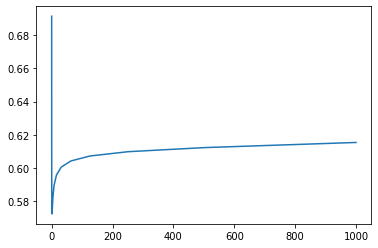

In [9]:
find_c(year_list, None, np.logspace(-3, 3, 21))

c_list=[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2. ]
w=None c=1.1 loss=0.572189611691259


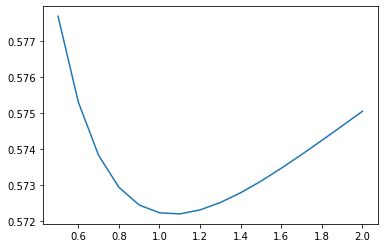

In [10]:
find_c(year_list, None, np.linspace(0.5, 2, 16))

### Weighted Logistic Regression

In [11]:
def find_w(year_list, w_list, c_list):
    loss_array = cv_w_c(year_list, w_list, c_list)
    a = divmod(loss_array.argmin(), loss_array.shape[-1])
    print('w_list={}'.format(w_list))
    print('w={} c={} loss={}'.format(w_list[a[0]], c_list[a[1]], loss_array[a]))
    plt.plot(w_list, loss_array[:, a[1]])
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


w_list=[ 0.          0.1         0.16681005  0.27825594  0.46415888  0.77426368
  1.29154967  2.15443469  3.59381366  5.9948425  10.        ]
w=2.1544346900318834 c=3.981071705534969 loss=0.5614642936626082


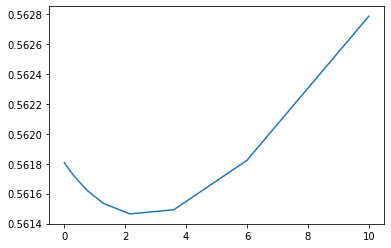

In [12]:
find_w(year_list,
       np.concatenate([np.zeros(1), np.logspace(-1, 1, 10)]),
       np.logspace(-3, 3, 21))

w_list=[1.  1.5 2.  2.5 3.  3.5 4. ]
w=2.5 c=3.981071705534969 loss=0.5614545447865565


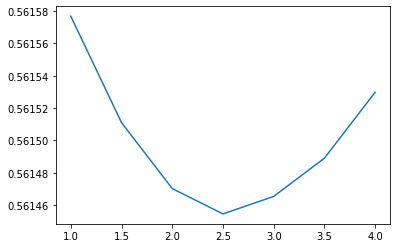

In [13]:
find_w(year_list,
       np.linspace(1, 4, 7),
       np.logspace(-3, 3, 21))

c_list=[2.  2.2 2.4 2.6 2.8 3.  3.2 3.4 3.6 3.8 4.  4.2 4.4 4.6 4.8 5.  5.2 5.4
 5.6 5.8 6.  6.2 6.4 6.6 6.8 7.  7.2 7.4 7.6 7.8 8. ]
w=2.5 c=3.6 loss=0.56132191005223


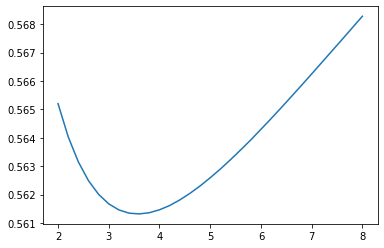

In [14]:
find_c(year_list, 2.5, np.linspace(2, 8, 31))

## Make predication

In [15]:
def predict(w, c, filename):
    year = 2018

    sr = season_result[season_result.Season == year]
    x_sr = encode_team(sr)
    y_sr = np.ones(x_sr.shape[0], dtype=np.int64)
    x_train = sp.sparse.vstack([x_sr, -x_sr])
    y_train = np.concatenate([y_sr, -y_sr])
    log_ratio = np.concatenate([sr.log_ratio, sr.log_ratio])

    x_test = encode_team(sample_submission)

    if w is None:
        w_train = None
    else:
        w_train = w * log_ratio.min() + log_ratio

    cls = LogisticRegression(C=c)
    cls.fit(x_train, y_train, w_train)
    col = list(cls.classes_).index(1)
    y_pred = cls.predict_proba(x_test)[:, col]

    submission = pd.DataFrame()
    submission['ID'] = sample_submission.ID
    submission['Pred'] = y_pred
    submission.to_csv(filename, index=False)

    return cls

In [16]:
lr = predict(w=None, c=1.1, filename='predict_with_logistic.csv')
wlr = predict(w=2.5, c=3.6, filename='predict_with_weighted_logistic.csv')

## Team score

In [17]:
team_score = wlr.coef_[0]
tourney_teams = sorted(set(sample_submission.team_a) | set(sample_submission.team_b))

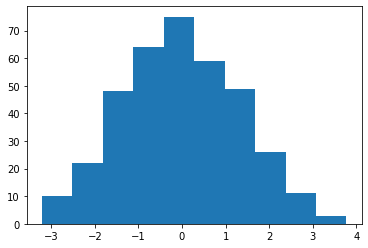

In [18]:
plt.hist(team_score)
plt.show()

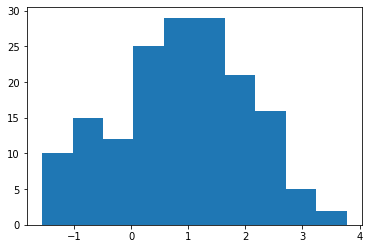

In [19]:
plt.hist(team_score[tourney_teams])
plt.show()